# Naive Attention-56 Model with CIFAR-10

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
#from utils.preprocess import CIFAR_preprocess, add_noise
from utils.NAL_CIFAR import ResNet56_NAL
from utils.residual_unit_CIFAR import residual_unit
from utils.NAL_block import NAL_stage_1, NAL_stage_2, NAL_stage_3
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load CIFAR-10 Data

In [3]:
## dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

train_num = int(len(x_train) * 0.8)
x_val = x_train[train_num:, :, :, :]
y_val = y_train[train_num:]
y_val = y_val.reshape(-1)
x_train = x_train[:train_num, :, :, :]
y_train = y_train[:train_num]
y_train = y_train.reshape(-1)

y_test = y_test.reshape(-1)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_validation shape:', x_val.shape)
print('y_validation shape:', y_val.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (40000, 32, 32, 3)
y_train shape: (40000,)
x_validation shape: (10000, 32, 32, 3)
y_validation shape: (10000,)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000,)


In [4]:
# calculate mean for each channel
mean = np.array(np.mean(x_train, axis=(0, 1, 2))).reshape([1,1,1,3])
x_train = x_train-mean
x_val = x_val - mean
x_test = x_test - mean

## Data Augmentation

In [5]:
## expand the original image to 40x40, and use random crop 32x32

def processing(image):
    pic = np.zeros(shape = (40, 40, 3))
    for c in range(image.shape[2]):
        a = image[:, :, c]
        a = np.pad(a, (4, 4))
        pic[:, :, c] = a
    pic = tf.image.random_crop(pic, [32, 32, 3], seed = 0)
    return pic

In [6]:
train_datagen = ImageDataGenerator(
            horizontal_flip=True,
            preprocessing_function=processing,
            validation_split=0.2)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_datagen.fit(x_train)
val_datagen.fit(x_val)
test_datagen.fit(x_test)

batch_size = 64
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

## Build up Naive Attention-56 Network

In [7]:
img_input = Input(shape=(32, 32, 3))
output = ResNet56_NAL(img_input)
model = Model(img_input, output)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Train the Model

In [9]:
## build a learning rate call back

def lr_schedule(epoch):
    lr = 0.1
    if epoch > 100:
        lr *= 1e-1
    elif epoch > 150:
        lr *= 1e-2
        
    print('Learning rate:', lr)
    return lr
lr_callback = LearningRateScheduler(lr_schedule)

## build an early stopping call back
early_stopper = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

In [10]:
## use nesterov SGD as mentioned in the paper
model.compile(optimizer = tf.keras.optimizers.SGD(lr_schedule(0), momentum=0.9, nesterov=True, name='SGD', decay = 0.0001),
             loss='sparse_categorical_crossentropy',
             metrics = 'accuracy')

Learning rate: 0.1


In [11]:
start = time.time()
history = model.fit(train_generator, validation_data=val_generator, epochs = 180, callbacks=[lr_callback, early_stopper]) # 256
end = time.time()
print("Time taken by above cell is {} min.".format((end-start)/60))

Learning rate: 0.1
Epoch 1/180
625/625 [==============================] - 133s 213ms/step - loss: 1.7431 - accuracy: 0.3563 - val_loss: 2.0114 - val_accuracy: 0.3531 - lr: 0.1000
Learning rate: 0.1
Epoch 2/180
625/625 [==============================] - 130s 209ms/step - loss: 1.4324 - accuracy: 0.4827 - val_loss: 1.3900 - val_accuracy: 0.4978 - lr: 0.1000
Learning rate: 0.1
Epoch 3/180
625/625 [==============================] - 131s 210ms/step - loss: 1.2832 - accuracy: 0.5407 - val_loss: 1.3493 - val_accuracy: 0.5420 - lr: 0.1000
Learning rate: 0.1
Epoch 4/180
625/625 [==============================] - 132s 211ms/step - loss: 1.1788 - accuracy: 0.5790 - val_loss: 1.3309 - val_accuracy: 0.5390 - lr: 0.1000
Learning rate: 0.1
Epoch 5/180
625/625 [==============================] - 135s 217ms/step - loss: 1.0775 - accuracy: 0.6154 - val_loss: 1.1864 - val_accuracy: 0.5903 - lr: 0.1000
Learning rate: 0.1
Epoch 6/180
625/625 [==============================] - 135s 216ms/step - loss: 1.0076 

#### Plot

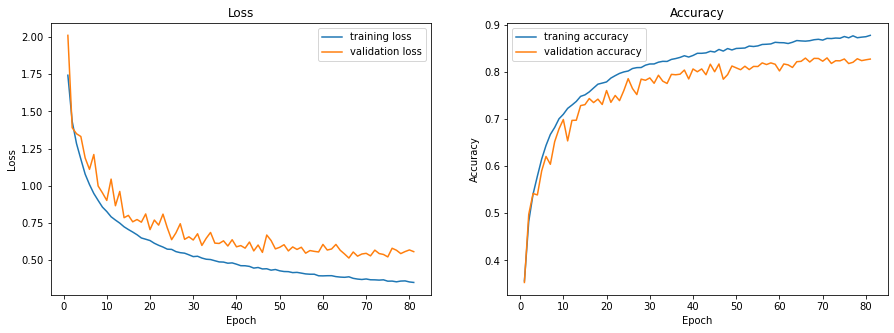

In [12]:
plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 81+1), history.history['loss'], label = 'training loss')
plt.plot(range(1, 81+1), history.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, 81+1), history.history['accuracy'], label = 'traning accuracy')
plt.plot(range(1, 81+1), history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

In [13]:
# evaluation
val_scores = model.evaluate(val_generator, verbose=0)
test_scores = model.evaluate(test_generator, verbose=1)
print('validation loss:', val_scores[0])
print('validation accuracy:', val_scores[1])
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

157/157 [==============================] - 3s 20ms/step - loss: 0.5835 - accuracy: 0.8205
validation loss: 0.5560423135757446
validation accuracy: 0.8276000022888184
Test loss: 0.5834886431694031
Test accuracy: 0.8205000162124634


## Save the Model

In [41]:
## save the best model in a dictionary
#save_dir = "./save_models/"
#if not os.path.exists(save_dir):
#    os.makedirs(save_dir)

## Save your model
#save_params = model.save_model()
#with open("./save_models/best_model.pkl", "wb") as output_file:
#    pickle.dump(save_params, output_file)

#model.save('ResidualAttention56_CIFAR10_model.h5')

#history.model.save('./MODEL')

In [14]:
## sava the weights
model.save_weights('NaiveAttention56_CIFAR10_weights.h5')